# Quantum benchmark

## I - Introduction

## II - Packages

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score, KFold
#Import classical libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import functools

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
import logging

import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer

from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
import qiskit

In [32]:
import warnings
warnings.filterwarnings('ignore')

## III - Data 

In [33]:
# Read out CSV

df = pd.read_csv('santander_transaction.csv', sep=',')


In [34]:
%%script false --no-raise-error

import sweetviz as sv

#EDA using Autoviz
sweet_report = sv.analyze(df)

#Saving results to HTML file
sweet_report.show_html('sweet_report.html')

## IV - Modelisation

### Classical

In [35]:

df_labels = df['target']
df.drop(['target'],axis = 1,inplace = True)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=42)

---

## Dimensionality reduction

In [37]:
np.unique(df_labels)

array([0., 1.])

In [38]:
from sklearn.preprocessing import StandardScaler

In [39]:
# Standardizing the features


In [40]:
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)


In [41]:
#pca = PCA(n_components=2)
pca = PCA(n_components=2)
pca = pca.fit(X_train)

In [42]:
df_pca_train = pca.transform(X_train)
df_pca_test = pca.transform(X_test)

In [43]:
df_pca_train = pd.DataFrame(data = df_pca_train
             , columns = ['pc_1', 'pc_2'])

df_pca_test = pd.DataFrame(data = df_pca_test
             , columns = ['pc_1', 'pc_2'])

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=BrokenPipeError(32, 'Broken pipe')>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.10/3.10.6_1/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/unix_events.py", line 675, in write
    n = os.write(self._fileno, data)
BrokenPipeError: [Errno 32] Broken pipe


In [44]:
df_pca_train.head()

,pc_1,pc_2
0,-1.939998,-1.229852
1,2.959007,0.852913
2,-1.929760,-1.846541
3,0.375061,-0.011576
4,0.041004,3.544161


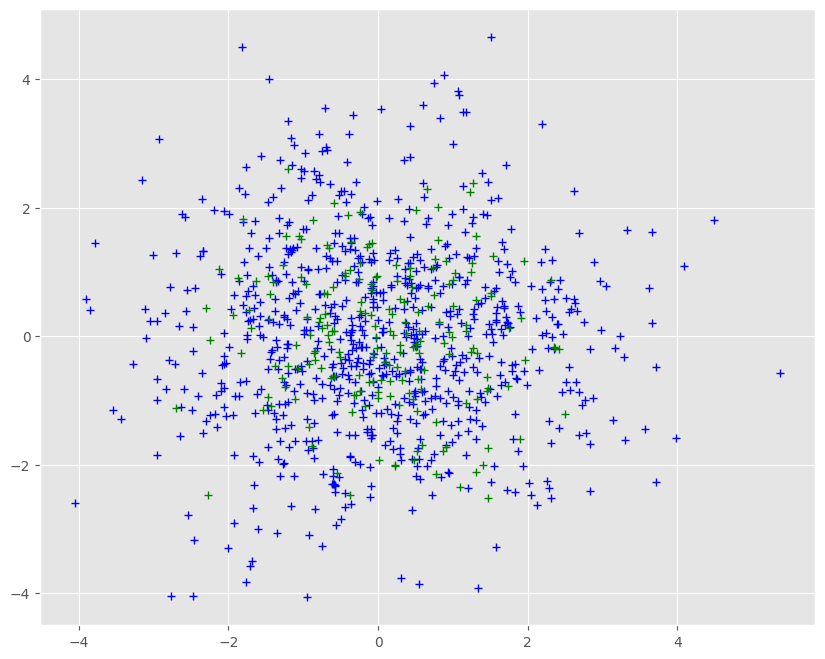

In [45]:
plt.figure(figsize=(10,8))
plt.plot(df_pca_train.iloc[:,0], df_pca_train.iloc[:,1], 'b+')
plt.plot(df_pca_test.iloc[:,0], df_pca_test.iloc[:,1], 'g+')
#plt.plot(df.index, feature_2, 'g+')

In [46]:
#n_dim = len(df_pca_train.columns)
n_dim = len(df_pca_train.columns)

In [47]:
n_dim

2

## Split train test 

In [48]:
# Split dataset into train and test

#sample_train, sample_test, label_train, label_test = train_test_split(
#     df_pca_train, y_train, test_size=0.2, random_state=22)

sample_train = df_pca_train.to_numpy()
sample_test = df_pca_test.to_numpy()
# Normalize

#std_scale = StandardScaler().fit(sample_train)
#sample_train = std_scale.transform(sample_train)
#sample_test = std_scale.transform(sample_test)

# Scale for better fit within the feature map

samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select a sample for a better control of the research and wall time

#train_size = 800#160
#sample_train = sample_train[:train_size]
#label_train = label_train[:train_size]

#test_size = 200 #40
#sample_test = sample_test[:test_size]
#label_test = label_test[:test_size]

In [49]:
# Basic parameters for hybrid model

seed = 8500
feature_dim = n_dim
num_reps = 2
num_shots =256 


## Hybrid

In [50]:
from sklearn.model_selection import cross_validate
from tqdm import tqdm
def evaluate_ml_model(_models, X, y, n_fold=10, metric='precision'):
    ''' Function to evaluate a ML and QML model with a list of metrics
    
    
    '''
    results = pd.DataFrame()
    kfold = KFold(n_splits=n_fold)
    columns = []
    for name, model in tqdm(_models):
        # -------------------
        # Variables initialization 
        _df = pd.DataFrame()
        names = []
        means = []
        stds = []
        
        # -------------------
        # k-fold Cross validation
        cv_results = cross_validate(model, X, y, cv=kfold, scoring=metric)
        
        # -------------------
        # Compute the mean and standard deviation 
        for _name, _array in cv_results.items():
            names.append(_name)
            means.append(round(100*_array.mean(), 2))
            stds.append(round(100*_array.std(), 2))
        # -------------------
        # Save the results in a dataframe 
        _df =  pd.DataFrame([means, stds], columns=names)
        columns.extend([name+' mean (%)', name+' std (%)'])
        #results = results.join(_df, on=_df.index)
        results = results.append(_df)
    results.index = columns
    print(results)
    return results

In [51]:
# Define feature_map

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=num_reps)

# Define the backend
backend = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=num_shots, seed_simulator=seed, seed_transpiler=seed
)

# Define the kernel

kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

# Model run
svc = SVC(kernel=kernel.evaluate)
#svc.fit(sample_train, label_train)
#score = svc.score(sample_test, label_test)

#print(f"Callable kernel classification test score: {score}")

In [86]:
models = []
#models.append(('LR', LogisticRegression(max_iter=1000, random_state=42)))
#models.append(('KNN', KNeighborsClassifier(n_neighbors=7)))
#models.append(('CART', DecisionTreeClassifier(random_state=42)))
#models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC(random_state=42)))
models.append(('QSVC', svc))

_metrics = ['precision', 'recall', 'f1', 'accuracy',  'matthews_corrcoef','balanced_accuracy']


In [87]:
df_results = pd.DataFrame()

In [ ]:
df_results = evaluate_ml_model(models, X_train, y_train, n_fold=10, metric=_metrics)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

In [ ]:
df_results

In [ ]:
j = 0
for i in range(int(len(df_results.index)/2)):

    print(f'{df_results.iloc[j].name.split()[0]} & {df_results.iloc[j][2]} ({df_results.iloc[j+1][2]}) & {df_results.iloc[j][3]} ({df_results.iloc[j+1][3]}) &  {df_results.iloc[j][4]} ({df_results.iloc[j+1][4]}) & {df_results.iloc[j][6]} ({df_results.iloc[j+1][6]}) & {df_results.iloc[j][7]} ({df_results.iloc[j+1][7]}) \\')
    
    j+=2

## Pennylane

In [69]:
from pennylane import numpy as np

In [70]:
# Angle Encoding

num_qubits = n_dim

dev = qml.device('default.qubit', wires = num_qubits)

@qml.qnode(dev)
def circuit(parameters, data):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = data, wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = parameters, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))

In [71]:
num_layers = 5
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

#print(weights_init, bias_init)

In [72]:
circuit(weights_init, sample_train[0])

tensor(0.19311142, requires_grad=True)

In [73]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [74]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [75]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [76]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [77]:
Y = np.array(label_train * 2 - np.ones(len(label_train)),requires_grad=True)  # shift label from {0, 1} to {-1, 1}
X = np.array(sample_train, requires_grad=True)

for i in range(5):
    print("X = {}, Y = {: d}".format(list(X[i]), int(Y[i])))

X = [tensor(-0.55282542, requires_grad=True), tensor(-0.34920584, requires_grad=True)], Y = -1
X = [tensor(0.4880937, requires_grad=True), tensor(0.12841323, requires_grad=True)], Y = -1
X = [tensor(-0.55065024, requires_grad=True), tensor(-0.49062472, requires_grad=True)], Y = -1
X = [tensor(-0.06093178, requires_grad=True), tensor(-0.06983122, requires_grad=True)], Y = -1
X = [tensor(-0.13191084, requires_grad=True), tensor(0.74556922, requires_grad=True)], Y = -1


In [78]:
opt = AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-08)
batch_size = 10

In [79]:
import warnings
warnings.filterwarnings('ignore')

In [80]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0
ccost = 0 
for it in range(250):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    prec = metrics.f1_score(Y, predictions, average='binary', pos_label=1)
    if  prec > abest or ((prec == abest) and (cost(weights, bias, X, Y) < ccost)):
        wbest = weights
        bbest = bias
        abest = prec
        ccost = cost(weights, bias, X, Y)
        print("New Best:")
    print(
        "Iter: {:5d} | Cost: {:0.7f} | f1: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

New Best:
Iter:     1 | Cost: 0.7801584 | f1: 0.0368664 
Iter:     2 | Cost: 0.8629578 | f1: 0.0000000 
Iter:     3 | Cost: 0.8672886 | f1: 0.0000000 
Iter:     4 | Cost: 0.7943621 | f1: 0.0000000 
Iter:     5 | Cost: 0.7755160 | f1: 0.0192308 
New Best:
Iter:     6 | Cost: 0.8276479 | f1: 0.0759494 
New Best:
Iter:     7 | Cost: 0.8409076 | f1: 0.1120000 
Iter:     8 | Cost: 0.8067122 | f1: 0.0452489 
Iter:     9 | Cost: 0.7821277 | f1: 0.0285714 
Iter:    10 | Cost: 0.7769773 | f1: 0.0194175 
Iter:    11 | Cost: 0.7994113 | f1: 0.0098039 
Iter:    12 | Cost: 0.8051553 | f1: 0.0000000 
Iter:    13 | Cost: 0.7860530 | f1: 0.0097087 
Iter:    14 | Cost: 0.8413890 | f1: 0.0836820 
Iter:    15 | Cost: 0.8540959 | f1: 0.0979592 
Iter:    16 | Cost: 0.8022269 | f1: 0.0000000 
Iter:    17 | Cost: 0.8030726 | f1: 0.0000000 
Iter:    18 | Cost: 0.8082857 | f1: 0.0000000 
Iter:    19 | Cost: 0.7871901 | f1: 0.0000000 
Iter:    20 | Cost: 0.7863649 | f1: 0.0098039 
Iter:    21 | Cost: 0.8511075 

In [81]:
Yte = np.array(label_test * 2 - np.ones(len(label_test)))
Xte = np.array(normalize(sample_test))

In [82]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 1.1753575596590478, Accuracy: 47.0%


In [83]:
print(metrics.classification_report(predictions,Yte))

              precision    recall  f1-score   support

        -1.0       0.41      0.81      0.54        78
         1.0       0.67      0.25      0.37       122

    accuracy                           0.47       200
   macro avg       0.54      0.53      0.46       200
weighted avg       0.57      0.47      0.44       200



In [84]:
print(metrics.classification_report(predictions,Yte))

              precision    recall  f1-score   support

        -1.0       0.41      0.81      0.54        78
         1.0       0.67      0.25      0.37       122

    accuracy                           0.47       200
   macro avg       0.54      0.53      0.46       200
weighted avg       0.57      0.47      0.44       200



In [85]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    ''')



    Precision: 67.39%
    Recall: 25.41%
    f1: 36.9%
    Accuracy: 47.0%
    Balanced accuracy: 53.09%
    Matthew corcorref: 7.16%
    
